In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [ ]:
from google.colab import drive
import os
from glob import glob

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
dataset_path = "/content/drive/MyDrive/colab/lol_dataset/"
train_low = sorted(glob(os.path.join(dataset_path, "our485/low/*.png")))
train_high = sorted(glob(os.path.join(dataset_path, "our485/high/*.png")))
test_low = sorted(glob(os.path.join(dataset_path, "eval15/low/*.png")))
test_high = sorted(glob(os.path.join(dataset_path, "eval15/high/*.png")))

# Print dataset sizes
print(f"✅ Training Images: {len(train_low)}, Testing Images: {len(test_low)}")

# Verify dataset exists
if len(train_low) == 0 or len(test_low) == 0:
    print("❌ Error: Dataset not found! Check the dataset path.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Training Images: 485, Testing Images: 15


In [ ]:
class LowLightDataset(Dataset):
    def __init__(self, low_images, high_images, transform=None):
        self.low_images = low_images
        self.high_images = high_images
        self.transform = transform

    def preprocess_image(self, image):
        """Convert image to grayscale and apply edge detection."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (3, 3), 0)
        laplacian = cv2.Laplacian(blur, cv2.CV_64F)
        laplacian = np.expand_dims(laplacian, axis=-1)  # Add channel dimension
        return laplacian

    def __getitem__(self, index):
        low_img = cv2.imread(self.low_images[index])
        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        high_img = cv2.imread(self.high_images[index])
        high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)

        # Compute edge map
        edges = self.preprocess_image(low_img)

        # Stack to create 4-channel input (RGB + edges)
        low_img = np.concatenate((low_img, edges), axis=-1)

        # Convert to tensor and normalize
        if self.transform:
            low_img = self.transform(low_img)
            high_img = self.transform(high_img)

            # Explicitly cast to float32 to avoid type mismatch
            low_img = low_img.type(torch.float32)
            high_img = high_img.type(torch.float32)


        return low_img, high_img

    def __len__(self):
        return len(self.low_images)

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Resize((256, 256)),  # Resize to 256x256
])

# Create DataLoader
train_dataset = LowLightDataset(train_low, train_high, transform=transform)
test_dataset = LowLightDataset(test_low, test_high, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),  # 4 input channels (RGB + edges)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output 3 channels (RGB)
            nn.Sigmoid()  # Normalize to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model
model = UNet().cuda()


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for low_img, high_img in train_loader:
        low_img, high_img = low_img.cuda(), high_img.cuda()

        optimizer.zero_grad()
        output = model(low_img)
        loss = criterion(output, high_img)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.0373
Epoch [2/5], Loss: 0.0284
Epoch [3/5], Loss: 0.0244
Epoch [4/5], Loss: 0.0237
Epoch [5/5], Loss: 0.0234


✅ SSIM Score: 0.00013984875


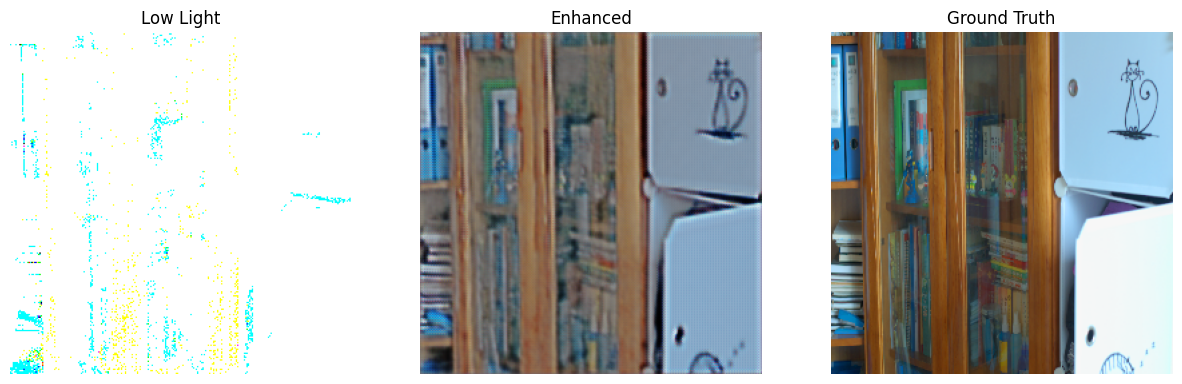

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def preprocess_image(image):
    """Convert image to grayscale and apply edge detection."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    laplacian = cv2.Laplacian(blur, cv2.CV_64F)
    laplacian = np.expand_dims(laplacian, axis=-1)  # Add channel dimension
    return laplacian

# Load and preprocess the test images
test_low_img = cv2.imread(test_low[0])
test_low_img = cv2.cvtColor(test_low_img, cv2.COLOR_BGR2RGB)
test_high_img = cv2.imread(test_high[0])
test_high_img = cv2.cvtColor(test_high_img, cv2.COLOR_BGR2RGB)

# Resize images to match model input size
H, W = 256, 256  # Adjust according to your model
test_low_img = cv2.resize(test_low_img, (W, H))
test_high_img = cv2.resize(test_high_img, (W, H))

# Compute edges and create 4-channel input
edges = preprocess_image(test_low_img)
test_low_img = np.concatenate((test_low_img, edges), axis=-1)  # RGB + Edges

# Convert to tensor
test_low_tensor = torch.tensor(test_low_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()

# Get enhanced image
model.eval()
with torch.no_grad():
    enhanced_tensor = model(test_low_tensor).cpu().numpy()

# Convert back to image format
enhanced_img = np.transpose(enhanced_tensor[0], (1, 2, 0))  # Rearrange dimensions

# Ensure dimensions match for SSIM calculation
if enhanced_img.shape != test_high_img.shape:
    test_high_img = cv2.resize(test_high_img, (enhanced_img.shape[1], enhanced_img.shape[0]))

# Compute SSIM Score
# ssim_score = ssim(enhanced_img, test_high_img, channel_axis=2)
# print("✅ SSIM Score:", ssim_score)

# Specify data_range for floating-point images
data_range = enhanced_img.max() - enhanced_img.min()  # Calculate data range of enhanced image
# Or, you could use: data_range = test_high_img.max() - test_high_img.min()

# Pass data_range to the ssim function
ssim_score = ssim(enhanced_img, test_high_img, channel_axis=2, data_range=data_range)
print("✅ SSIM Score:", ssim_score)

# Display Results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_low_img[..., :3])  # Show only RGB part
ax[0].set_title("Low Light")
ax[1].imshow(enhanced_img)
ax[1].set_title("Enhanced")
ax[2].imshow(test_high_img)
ax[2].set_title("Ground Truth")
for a in ax:
    a.axis("off")
plt.show()
